In [2]:
from mp_api.client import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pymatgen.core import Structure

In [3]:
api_key = "G8Y1MEs8Cq5taybjmq7kKYdGYJOoOCA0"  
with MPRester(api_key) as mpr:
    data = mpr.materials.summary.search(
        band_gap=(0, 5),
        num_elements=(1, 4),
        is_stable=True,
        is_metal=False,
        fields=["material_id", "band_gap", "structure"]
    )

records = [{k: v for k, v in d.dict().items() if v is not None} for d in data]
df = pd.DataFrame.from_records(records)
df['structure'] = df['structure'].apply(lambda s: Structure.from_dict(s) if isinstance(s, dict) else s)
df = df[df['structure'].apply(len) < 100].reset_index(drop=True)
df = df.sample(n=2500, random_state=17).reset_index(drop=True)
print(len(df))
df.head()

Retrieving SummaryDoc documents:   0%|          | 0/14307 [00:00<?, ?it/s]

2500


,material_id,structure,band_gap,fields_not_requested
0,mp-cqvev,"[[2.0523893 2.0523893 2.0523893] Rb, [ 2.05238...",2.0393,"[builder_meta, nsites, elements, nelements, co..."
1,mp-brdde,"[[3.3738624 2.22379525 0.50214352] Na, [3.441...",1.4867,"[builder_meta, nsites, elements, nelements, co..."
2,mp-bqlr,"[[1.32531688 2.41332718 6.01433839] K, [3.9759...",2.5733,"[builder_meta, nsites, elements, nelements, co..."
3,mp-cdpff,"[[2.28988855 2.28974031 1.53171696] Li, [4.953...",0.0398,"[builder_meta, nsites, elements, nelements, co..."
4,mp-xdt,"[[3.95966568 1.19692784 7.36662335] Ag, [ 7.42...",0.5351,"[builder_meta, nsites, elements, nelements, co..."


In [5]:
from dscribe.descriptors import SOAP
species = set()
for s in df["structure"]:
    species.update([str(sp) for sp in s.species])
species = list(species)

soap = SOAP(
    species=species,
    r_cut=4.5,
    n_max=4,
    l_max=3,
    average="outer",
    sparse=False
)

ase_structures = [AseAtomsAdaptor.get_atoms(s) for s in df["structure"]]
soap_features = np.array(soap.create(ase_structures))

soap_columns = [f"soap_{i}" for i in range(soap_features.shape[1])]
df_feat = pd.DataFrame(soap_features, columns=soap_columns)
df_feat["band_gap"] = df["band_gap"]



Number of features before cleaning: 237360
After VarianceThreshold: 53078

⏳ Removing highly correlated features (blockwise)...


  0%|          | 0/54 [00:00<?, ?it/s]

✅ Number of features after removing highly correlated columns: 13637


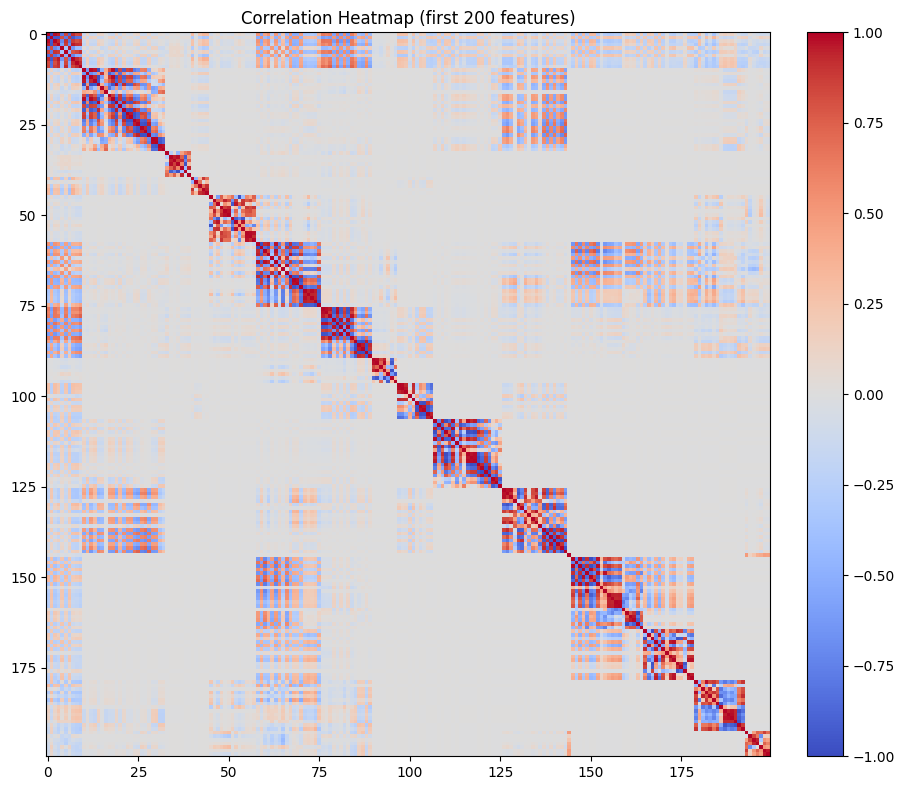

In [ ]:
from sklearn.feature_selection import VarianceThreshold
y = df_feat["band_gap"]
X_all_struc = df_feat.drop(columns=["band_gap"])
print(f"Number of features before cleaning: {X_all_struc.shape[1]}")

selector = VarianceThreshold(threshold=1e-5)
X_filtered = selector.fit_transform(X_all_struc)
selected_cols = X_all_struc.columns[selector.get_support()]
X_all_struc = pd.DataFrame(X_filtered, columns=selected_cols)
print(f"After VarianceThreshold: {X_all_struc.shape[1]}")

threshold = 0.99
to_drop = set()
block_size = 1000
cols = list(X_all_struc.columns)
n_cols = len(cols)

for i in tqdm(range(0, n_cols, block_size)):
    block = X_all_struc.iloc[:, i:i+block_size]
    corr_block = block.corr().abs()
    upper = corr_block.where(np.triu(np.ones(corr_block.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    to_drop.update(drop_cols)

X_struc = X_all_struc.drop(columns=list(to_drop), errors="ignore")
print(f"✅ Number of features after removing highly correlated columns: {X_struc.shape[1]}")

subset_cols = X_struc.columns[:200]
corr_matrix_sample = X_struc[subset_cols].corr(method="pearson")

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix_sample, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap (first 200 features)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300, random_state=17)
X_struc_pca = pca.fit_transform(X_struc)
print("After PCA:", X_struc_pca.shape)

After PCA: (2500, 300)


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [11]:
mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting mean formation energy): {baseline_mae:.4f} eV")

Baseline MAE (predicting mean formation energy): 1.0843 eV


Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

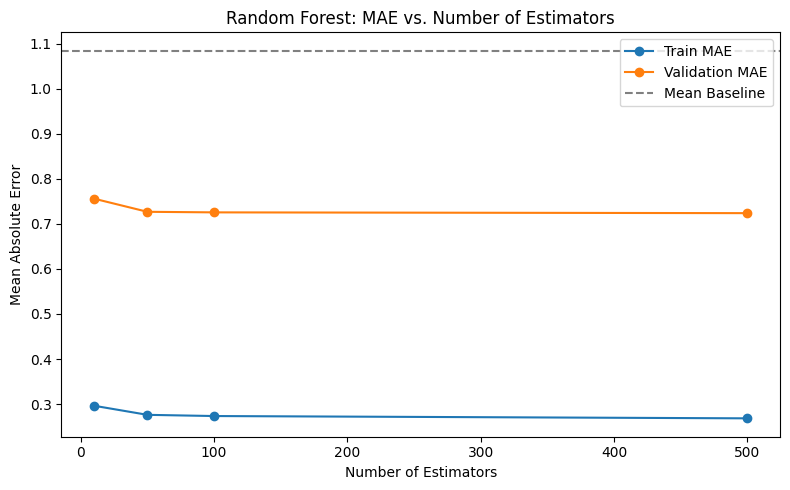

In [12]:
n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.show()

Training RF models:   0%|          | 0/8 [00:00<?, ?it/s]

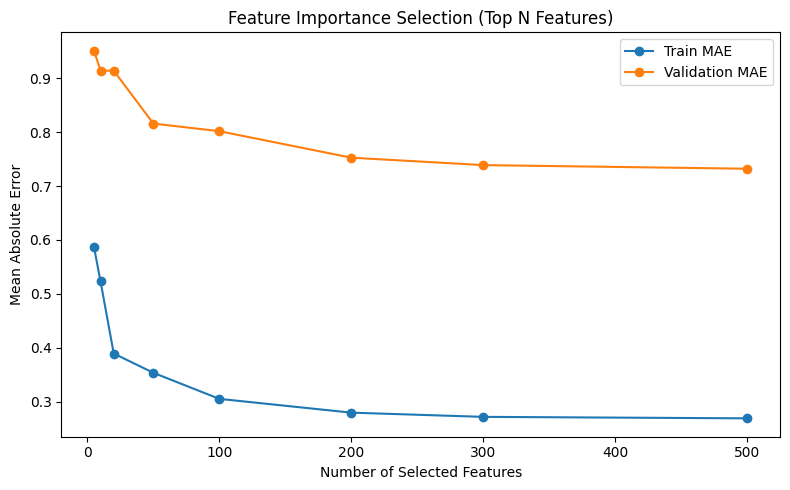

In [14]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
rf_base = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=-1)
rf_base.fit(X_train, y_train)
importances = rf_base.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
X_train_sorted = X_train[:, sorted_idx]
X_val_sorted = X_val[:, sorted_idx]

n_features_list = [5, 10, 20, 50, 100, 200, 300, 500]
train_mae = []
val_mae = []

for n in tqdm(n_features_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=-1)
    rf.fit(X_train_sorted[:, :n], y_train)
    y_train_pred = rf.predict(X_train_sorted[:, :n])
    y_val_pred = rf.predict(X_val_sorted[:, :n])
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    val_mae.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_mae, marker='o', label='Train MAE')
plt.plot(n_features_list, val_mae, marker='o', label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('Feature Importance Selection (Top N Features)')
plt.legend()
plt.tight_layout()
plt.show()

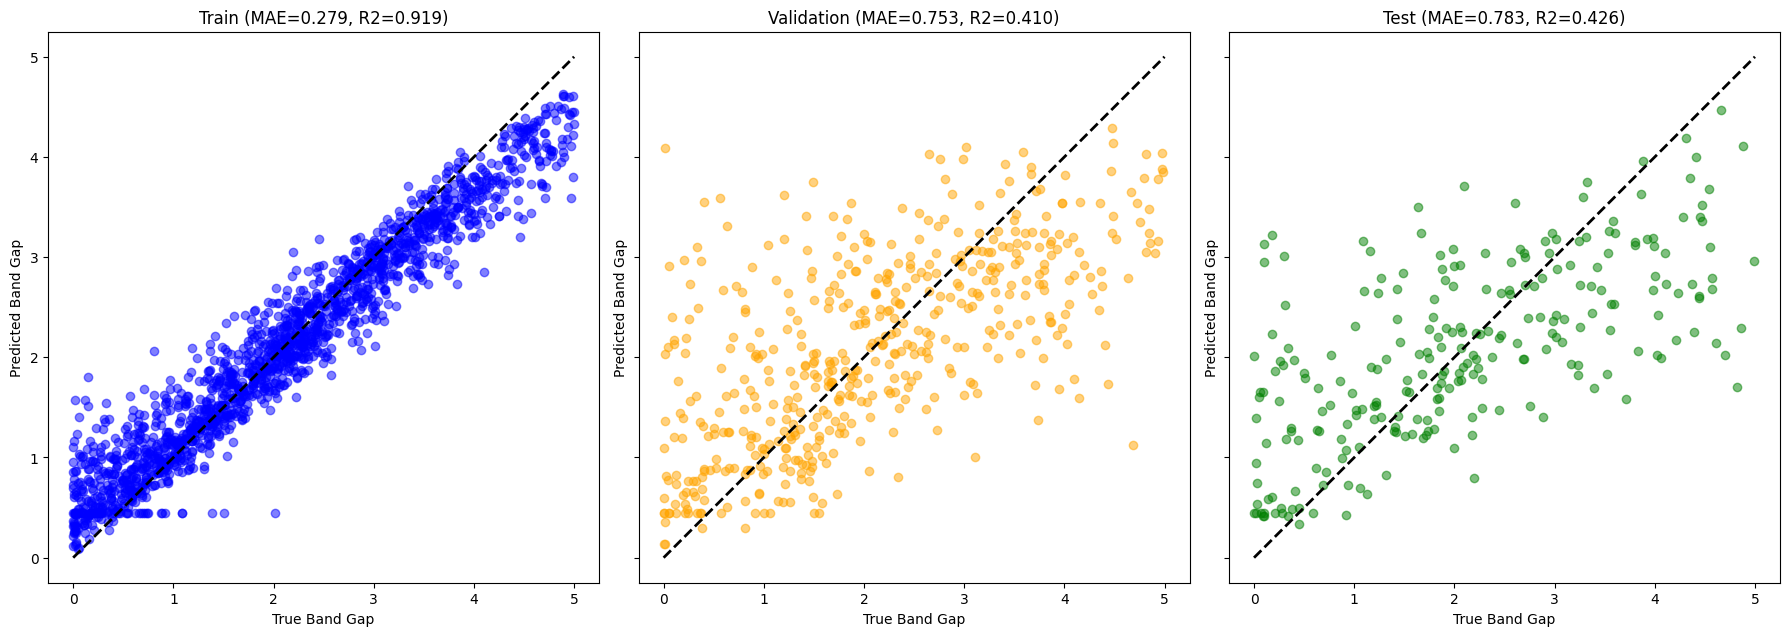

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score

best_n = 200
rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=-1)
rf_final.fit(X_train_sorted[:, :best_n], y_train)

X_train_final = X_train_sorted[:, :best_n]
X_val_final = X_val_sorted[:, :best_n]
X_test_final = X_test[:, sorted_idx][:, :best_n]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val = min(y_test.min(), y_val.min(), y_train.min())
max_val = max(y_test.max(), y_val.max(), y_train.max())

axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Band Gap')
axes[0].set_ylabel('Predicted Band Gap')
axes[0].set_aspect('equal', adjustable='box')

axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Band Gap')
axes[1].set_ylabel('Predicted Band Gap')
axes[1].set_aspect('equal', adjustable='box')

axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Band Gap')
axes[2].set_ylabel('Predicted Band Gap')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


In [ ]:
# Using SOAP structural descriptors and Random Forest regression, we achieved a validation R² of 0.41 and test R² of 0.43.
# The model captures overall trends but shows limited generalization due to the complex non-linear nature of band gap prediction.